In [2]:
import nibabel as nb 
import numpy as np
import pandas 
import seaborn as sns
import matplotlib.pyplot as plt
from Functional_Fusion.dataset import decompose_pattern_into_group_indiv_noise
from scripts import decomposing_variances
from scripts import make_atlas
#from scripts import bold_normalization 
import Functional_Fusion.dataset as ds
import Functional_Fusion.atlas_map as am

/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_8636/1065668393.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


In [21]:
#dentate data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='dentate', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d) #shape: 16,16,10,3934

#computing SEM for each condition: 
#std across subjects and runs divided by the square root of subjects x runs (256 sets of 3934 voxels)
#ddof means division by N-1 (unbiased estimator)

sem = np.std(data, axis=(0, 1), ddof=1) / np.sqrt(16 * 16)

sem_values_dentate = np.mean(sem, axis=1)  # Shape: (10,)

print(sem_values_dentate)

#average across subjects and runs and voxels for each condition

subj_avg = np.mean(data, axis=0) #shape: 16,10,3934

run_avg = np.mean(subj_avg, axis=0) #shape: 10,3934

cond_avg_dent = np.mean(run_avg, axis=1) #shape: 10

print(cond_avg_dent)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])



[0.01033993 0.01505129 0.01592733 0.01531526 0.01445609 0.01475379
 0.01498843 0.01550057 0.01491973 0.01514767]
[ 0.00224486  0.00245442  0.01333977 -0.00118769  0.00347054 -0.00300671
 -0.01035416  0.00958945 -0.00761015 -0.00894033]


In [14]:
#redn data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='rednucleus', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d)

#computing SEM for each condition: 
#std across subjects and runs divided by the square root of subjects x runs (256 sets of 3934 voxels)
#ddof means division by N-1 (unbiased estimator)

sem = np.std(data, axis=(0, 1), ddof=1) / np.sqrt(16 * 16)

sem_values_redn = np.mean(sem, axis=1)  # Shape: (10,)

print(sem_values_redn)

#average across subjects

subj_avg = np.mean(data, axis=0)

run_avg = np.mean(subj_avg, axis=0)

cond_avg_redn = np.mean(run_avg, axis=1)

print(cond_avg_redn)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])




vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
/Users/incehusain/Documents/GitHub/Pontine7T/env/lib/python3.9/site-packages/nibabel/nifti1.py:617: UserWarning: Extension size is not a multiple of 16 bytes; Assuming size is correct and hoping for the best
  warnings.warn(
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=27400) not divisible by 16, not SPM compatible; leaving at current value
v

[0.01041556 0.01593193 0.01617639 0.01572347 0.01577408 0.01506878
 0.01562139 0.01632255 0.01535457 0.01571381]
[ 0.00350441  0.0049634   0.00947999  0.00075478 -0.00232617 -0.0014441
 -0.00429931  0.00566744 -0.0092844  -0.00701604]


In [15]:
#olive data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='olive', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d)

#computing SEM for each condition: 
#std across subjects and runs divided by the square root of subjects x runs (256 sets of 3934 voxels)
#ddof means division by N-1 (unbiased estimator)

sem = np.std(data, axis=(0, 1), ddof=1) / np.sqrt(16 * 16)

sem_values_olive = np.mean(sem, axis=1)  # Shape: (10,)

print(sem_values_olive)

#average across subjects

subj_avg = np.mean(data, axis=0)

run_avg = np.mean(subj_avg, axis=0)

cond_avg_olive = np.mean(run_avg, axis=1)

print(cond_avg_olive)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])



vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
/Users/incehusain/Documents/GitHub/Pontine7T/env/lib/python3.9/site-packages/nibabel/nifti1.py:617: UserWarning: Extension size is not a multiple of 16 bytes; Assuming size is correct and hoping for the best
  warnings.warn(
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=31752) not divisible by 16, not SPM compatible; leaving at current value
v

[0.01041358 0.01579214 0.01655657 0.01575298 0.01509866 0.01511088
 0.01589587 0.01611282 0.01569088 0.01579235]
[ 0.00643612  0.00298557  0.00521756  0.00505443  0.00132745 -0.00461602
 -0.00962462  0.00994499 -0.00793588 -0.00878961]


In [16]:
#pons data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='pontine', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d)

#computing SEM for each condition: 
#std across subjects and runs divided by the square root of subjects x runs (256 sets of 3934 voxels)
#ddof means division by N-1 (unbiased estimator)

sem = np.std(data, axis=(0, 1), ddof=1) / np.sqrt(16 * 16)

sem_values_pons = np.mean(sem, axis=1)  # Shape: (10,)

print(sem_values_pons)

#average across subjects

subj_avg = np.mean(data, axis=0)

run_avg = np.mean(subj_avg, axis=0)

cond_avg_pons = np.mean(run_avg, axis=1)

print(cond_avg_pons)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])



vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
/Users/incehusain/Documents/GitHub/Pontine7T/env/lib/python3.9/site-packages/nibabel/nifti1.py:617: UserWarning: Extension size is not a multiple of 16 bytes; Assuming size is correct and hoping for the best
  warnings.warn(
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at current value
vox offset (=134424) not divisible by 16, not SPM compatible; leaving at curren

[0.00998548 0.01520285 0.01617042 0.01544168 0.01467345 0.01466461
 0.01507982 0.01570397 0.01511728 0.01531584]
[ 0.00312729 -0.00451581  0.00193929  0.00092854 -0.00226789 -0.00392753
 -0.00101905  0.00690104 -0.00042661 -0.00073925]


In [17]:
#thalamus data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='thalamus', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d)

#computing SEM for each condition: 
#std across subjects and runs divided by the square root of subjects x runs (256 sets of 3934 voxels)
#ddof means division by N-1 (unbiased estimator)

sem = np.std(data, axis=(0, 1), ddof=1) / np.sqrt(16 * 16)

sem_values_thalamus = np.mean(sem, axis=1)  # Shape: (10,)

print(sem_values_thalamus)

#average across subjects

subj_avg = np.mean(data, axis=0)

run_avg = np.mean(subj_avg, axis=0)

cond_avg_thalamus = np.mean(run_avg, axis=1)

print(cond_avg_thalamus)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])



[0.00465814 0.00664655 0.00679391 0.0065555  0.00633671 0.00635283
 0.00650552 0.00678235 0.00645288 0.00650508]
[ 2.75664719e-03  8.54102964e-04  3.98791960e-03  4.66870032e-05
  2.44709811e-05 -2.08492712e-03 -1.27704808e-03  7.14029172e-04
 -3.84814221e-03 -1.17373950e-03]


In [18]:
#cereb gray data BOLDMNI

flat_data = decomposing_variances.get_structure_data(structure='cereb_gray', data_dir='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group')

cond_vec = np.tile(np.arange(1,11),16)

part_vec = np.repeat(np.arange(1,17), 10)

flat_data = ds.remove_baseline(flat_data[0],part_vec)

tensor_4d = decomposing_variances.flat2ndarray(flat_data, cond_vec, part_vec)

data = np.nan_to_num(tensor_4d)

#computing SEM for each condition: 
#std across subjects and runs divided by the square root of subjects x runs (256 sets of 3934 voxels)
#ddof means division by N-1 (unbiased estimator)

sem = np.std(data, axis=(0, 1), ddof=1) / np.sqrt(16 * 16)

sem_values_cerebg = np.mean(sem, axis=1)  # Shape: (10,)

print(sem_values_cerebg)

#average across subjects

subj_avg = np.mean(data, axis=0)

run_avg = np.mean(subj_avg, axis=0)

cond_avg_cereb_gray = np.mean(run_avg, axis=1)

print(cond_avg_cereb_gray)

#condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "N_back", "Act_Obs", "Flex_Ext", "Rest"])



[0.01047546 0.01706634 0.01871232 0.01721545 0.01602045 0.01611443
 0.0166968  0.01817456 0.01672555 0.01697061]
[ 0.00577893  0.00025809  0.02435791  0.00173379  0.00254675 -0.00528998
 -0.00601337  0.00736007 -0.01711001 -0.01362216]


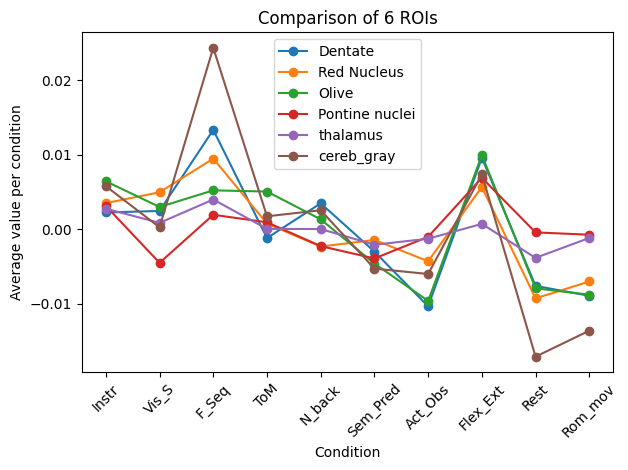

In [19]:
# Create x-axis labels (1 to 10 for the 10 conditions)
condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "Act_Obs", "Flex_Ext", "Rest", "Rom_mov"])

# Plot both lines
plt.plot(condition_labels, cond_avg_dent, marker='o', label='Dentate', linestyle='-')
plt.plot(condition_labels, cond_avg_redn, marker='o', label='Red Nucleus', linestyle='-')
plt.plot(condition_labels, cond_avg_olive, marker='o', label='Olive', linestyle='-')
plt.plot(condition_labels, cond_avg_pons, marker='o', label='Pontine nuclei', linestyle='-')
plt.plot(condition_labels, cond_avg_thalamus, marker='o', label='thalamus', linestyle='-')
plt.plot(condition_labels, cond_avg_cereb_gray, marker='o', label='cereb_gray', linestyle='-')



# Labels and title
plt.xlabel("Condition")
plt.ylabel("Average value per condition")
plt.title("Comparison of 6 ROIs")

plt.xticks(rotation=45, fontsize=10)

plt.legend()
plt.tight_layout()

# Show plot
plt.show()

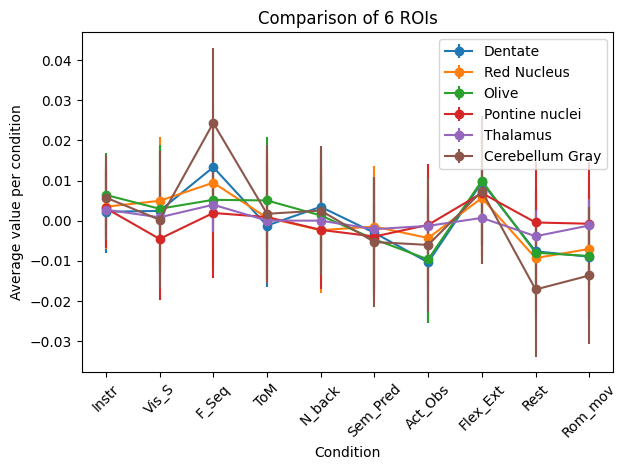

In [22]:
# Create x-axis labels (1 to 10 for the 10 conditions)
condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "Act_Obs", "Flex_Ext", "Rest", "Rom_mov"])

# Plot with error bars
plt.errorbar(condition_labels, cond_avg_dent, yerr=sem_values_dentate, marker='o', label='Dentate', linestyle='-')
plt.errorbar(condition_labels, cond_avg_redn, yerr=sem_values_redn, marker='o', label='Red Nucleus', linestyle='-')
plt.errorbar(condition_labels, cond_avg_olive, yerr=sem_values_olive, marker='o', label='Olive', linestyle='-')
plt.errorbar(condition_labels, cond_avg_pons, yerr=sem_values_pons, marker='o', label='Pontine nuclei', linestyle='-')
plt.errorbar(condition_labels, cond_avg_thalamus, yerr=sem_values_thalamus, marker='o', label='Thalamus', linestyle='-')
plt.errorbar(condition_labels, cond_avg_cereb_gray, yerr=sem_values_cerebg, marker='o', label='Cerebellum Gray', linestyle='-')

# Labels and title
plt.xlabel("Condition")
plt.ylabel("Average value per condition")
plt.title("Comparison of 6 ROIs")

plt.xticks(rotation=45, fontsize=10)

plt.legend()
plt.tight_layout()

# Show plot
plt.show()


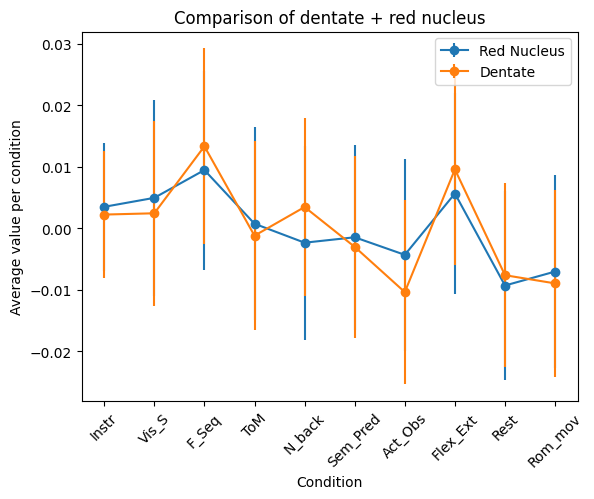

In [24]:
#dentate gives output to red nucleus

# Create x-axis labels (1 to 10 for the 10 conditions)
conditions = np.arange(1, 11)

# Plot both lines

plt.errorbar(condition_labels, cond_avg_redn, yerr=sem_values_redn, marker='o', label='Red Nucleus', linestyle='-')
plt.errorbar(condition_labels, cond_avg_dent, yerr=sem_values_dentate, marker='o', label='Dentate', linestyle='-')

# Labels and title
plt.xlabel("Condition")
plt.ylabel("Average value per condition")
plt.title("Comparison of dentate + red nucleus")
plt.legend()

plt.xticks(rotation=45, fontsize=10)


# Show plot
plt.show()

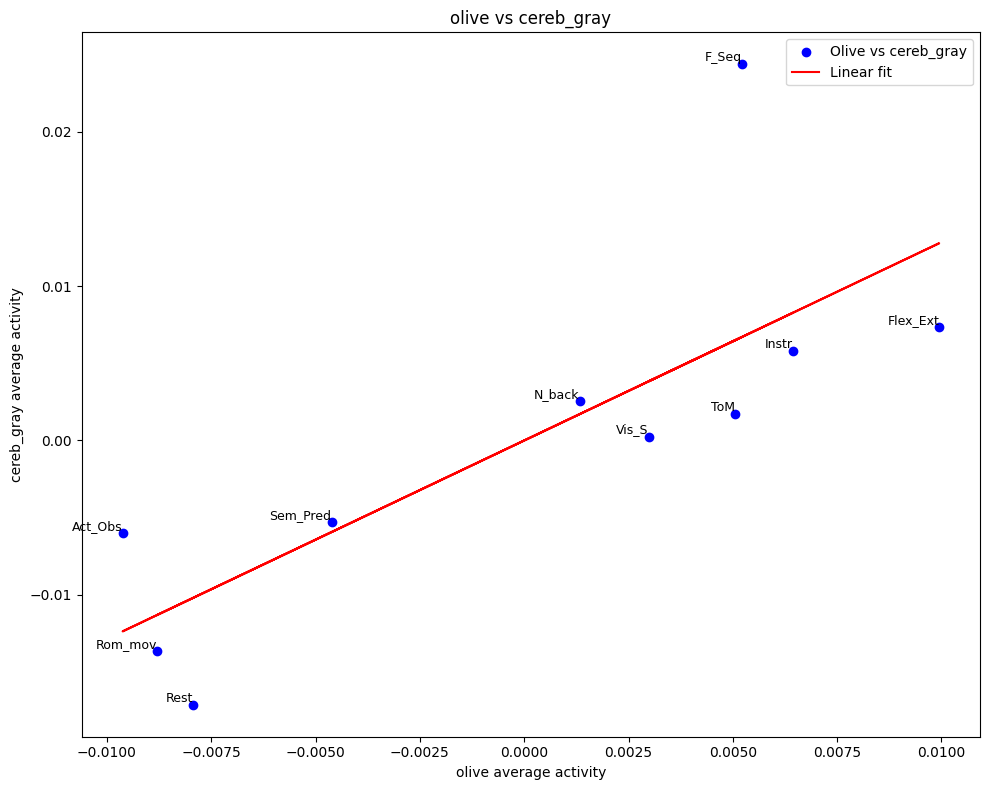

In [54]:
# Create x-axis labels (1 to 10 for the 10 conditions)
condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "Act_Obs", "Flex_Ext", "Rest", "Rom_mov"])

plt.figure(figsize=(10, 8))

cond_avgx = cond_avg_olive
cond_avgy = cond_avg_cereb_gray

# Plot the data of one region against another (e.g., Dentate vs Red Nucleus)
plt.scatter(cond_avgx, cond_avgy, label="Olive vs cereb_gray", color="blue")

# Optionally, fit and plot a linear regression line to the data
slope, intercept = np.polyfit(cond_avgx, cond_avgy, 1)  # Linear fit
plt.plot(cond_avgx, slope * cond_avgx + intercept, color="red", label="Linear fit")

# Labels and title
plt.xlabel("olive average activity")
plt.ylabel("cereb_gray average activity")
plt.title("olive vs cereb_gray")

for i in range(len(cond_avgx)):

    # Add condition labels next to each point
    plt.text(cond_avgx[i], cond_avgy[i], condition_labels[i], fontsize=9, color='black', ha='right', va='bottom')


# Add a legend and tidy up the plot
plt.legend()
plt.tight_layout()

# Show plot
plt.show()


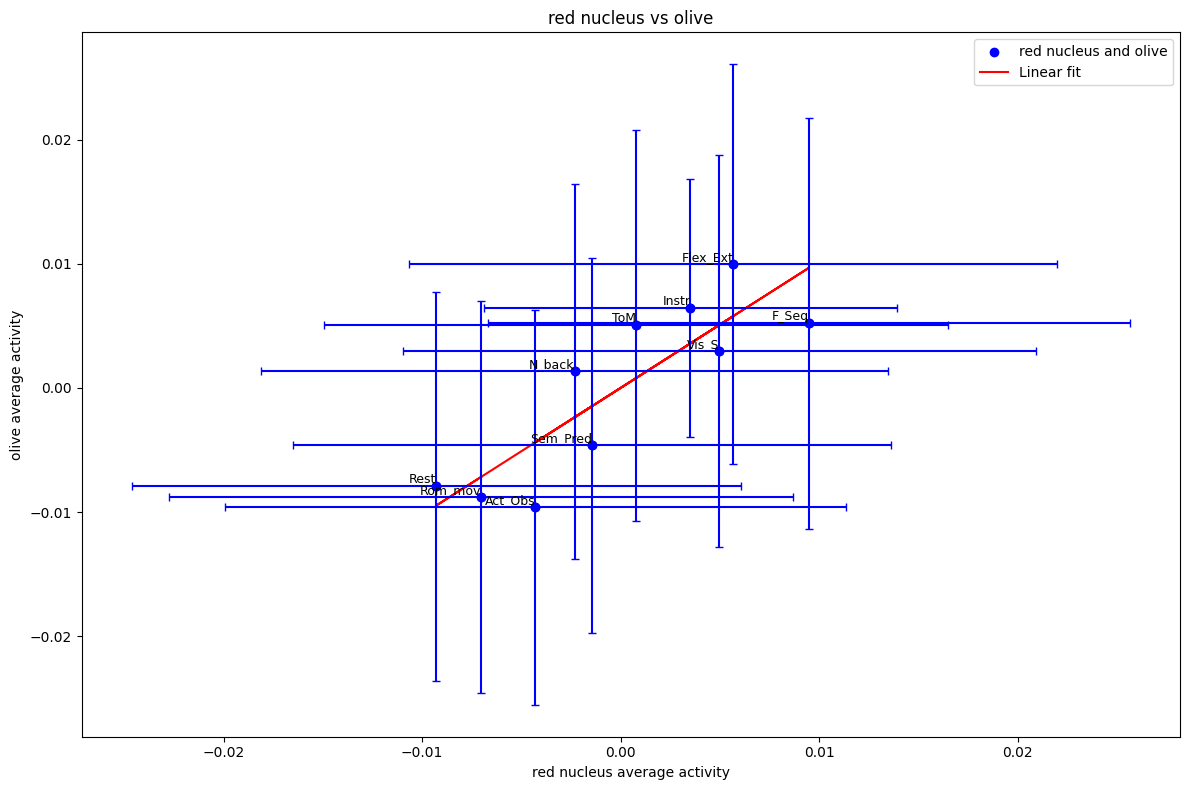

In [53]:
# Create x-axis labels (1 to 10 for the 10 conditions)

cond_avgx = cond_avg_olive
cond_avgy = cond_avg_cereb_gray

sem_valuesx = sem_values_olive 
sem_valuesy = sem_values_cerebg 

plt.figure(figsize=(12, 8))

condition_labels = np.array(["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "Act_Obs", "Flex_Ext", "Rest", "Rom_mov"])

# Scatter plot of Dentate vs Red Nucleus
plt.scatter(cond_avgx, cond_avgy, label="Olive and cereb_gray", color="blue")

# Optionally, fit and plot a linear regression line to the data
slope, intercept = np.polyfit(cond_avgx, cond_avgy, 1)  # Linear fit
plt.plot(cond_avgx, slope * cond_avgx + intercept, color="red", label="Linear fit")

# Add error bars if desired
for i in range(len(cond_avgx)):
    plt.errorbar(cond_avgx[i], cond_avgy[i], 
                 xerr=sem_valuesx[i], yerr=sem_valuesy[i], 
                 fmt='o', color='blue', capsize=3)

    # Add condition labels next to each point
    plt.text(cond_avgx[i], cond_avgy[i], condition_labels[i], fontsize=9, color='black', ha='right', va='bottom')

# Labels and title
plt.xlabel("olive average activity")
plt.ylabel("cereb_gray average activity")
plt.title("olive vs cereb_gray")

# Add a legend and tidy up the plot
plt.legend()
plt.tight_layout()

# Show plot
plt.show()
